<a href="https://colab.research.google.com/github/youngchul-sung/three-minutes-keras/blob/master/ex6_2_ae_conv_mnist_mc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

#########################################################
# Convolutional layer based AE with MNIST, Models/Class
#########################################################

###########################
# AE 모델링
###########################
from tensorflow import keras
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers
import numpy as np
import matplotlib.pyplot as plt


def save_history_history(fname, history_history, fold=''):
    np.save(os.path.join(fold, fname), history_history)


def load_history_history(fname, fold=''):
    history_history = np.load(os.path.join(fold, fname)).item(0)
    return history_history


def plot_acc(history, title=None):
    # summarize history for accuracy
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Accracy')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_loss(history, title=None):
    # summarize history for loss
    if not isinstance(history, dict):
        history = history.history

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    if title is not None:
        plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training data', 'Validation data'], loc=0)
    # plt.show()


def plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plot_acc(history)
    plt.subplot(1, 2, 2)
    plot_loss(history)


def plot_loss_acc(history):
    plot_loss(history, '(a) Loss trajectory')
    plt.show()
    plot_acc(history, '(b) Accracy trajectory')
    plt.show()


def plot_acc_loss(history):
    plot_acc(history, '(a) Accracy trajectory')
    plt.show()
    plot_loss(history, '(b) Loss trajectory')
    plt.show()


class DATA():
    def __init__(self):
        num_classes = 10

        (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
        img_rows, img_cols = x_train.shape[1:]

        if keras.backend.image_data_format() == 'channels_first':
            x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
            x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
            input_shape = (1, img_rows, img_cols)
        else:
            x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
            x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
            input_shape = (img_rows, img_cols, 1)

        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        x_train /= 255
        x_test /= 255

        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)
        
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.x_train, self.y_train = x_train, y_train
        self.x_test, self.y_test = x_test, y_test

TensorFlow 2.x selected.


Model: "ae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         296       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 1)           393       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          160      

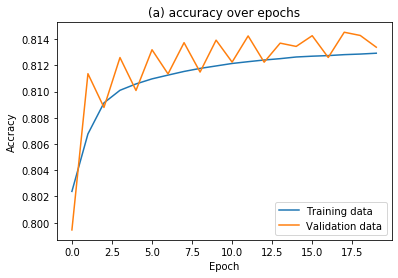

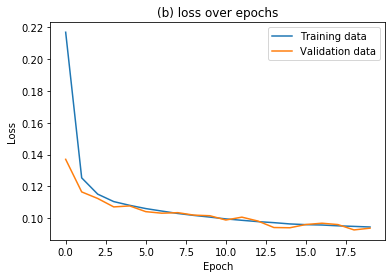

(10000, 28, 28, 1) (10000, 28, 28, 1)


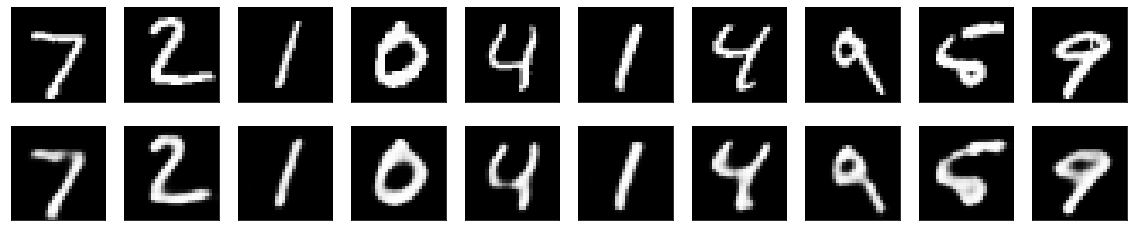

In [2]:
def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)


class AE(models.Model):
    def __init__(self, org_shape=(1, 28, 28)):
        # Input
        original = layers.Input(shape=org_shape)

        # encoding-1
        x = Conv2D(4, (3, 3))(original)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)

        # encoding-2
        x = Conv2D(8, (3, 3))(x)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)

        # encoding-3: encoding output: 7x7 pixels
        z = Conv2D(1, (7, 7))(x)

        # decoding-1
        y = Conv2D(16, (3, 3))(z)
        y = layers.UpSampling2D((2, 2))(y)

        # decoding-2
        y = Conv2D(8, (3, 3))(y)
        y = layers.UpSampling2D((2, 2))(y)

        # decoding-3
        y = Conv2D(4, (3, 3))(y)

        # decoding & Output
        decoded = Conv2D(1, (3, 3), activation='sigmoid')(y)

        super().__init__(original, decoded)
        self.compile(optimizer=optimizers.Adadelta(learning_rate=1.0), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])


def show_ae(autoencoder, data):
    x_test = data.x_test
    decoded_imgs = autoencoder.predict(x_test)
    print(decoded_imgs.shape, data.x_test.shape)

    if keras.backend.image_data_format() == 'channels_first':
        N, n_ch, n_i, n_j = x_test.shape
    else:
        N, n_i, n_j, n_ch = x_test.shape

    x_test = x_test.reshape(N, n_i, n_j)
    decoded_imgs = decoded_imgs.reshape(decoded_imgs.shape[0], n_i, n_j)
    
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i], cmap='gray')
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i], cmap='gray')
        # plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()
    

###########################
# 학습 및 확인
###########################
def main(epochs=20, batch_size=128):
    data = DATA()
    autoencoder = AE(data.input_shape)
    autoencoder.summary()

    history = autoencoder.fit(data.x_train, data.x_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_split=0.2)

    plot_acc(history, '(a) accuracy over epochs')
    plt.show()
    plot_loss(history, '(b) loss over epochs')
    plt.show()

    show_ae(autoencoder, data)
    plt.show()


if __name__ == '__main__':
    main()